In [1]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
from priordist import PriorDistributionCell

In [2]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [3]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

In [4]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Generate time intervals for navigation phases and bin into 1-second time bins
nav_timestamps = trial_timestamps[1:,:].T
nav_intervals = list()
delta = 1  # Size of time bin (in seconds)
for idx, intvl in enumerate(nav_timestamps):
    nav_start, nav_end = intvl
    nav_intervals.append(np.vstack((np.arange(nav_start, nav_end - delta, delta), np.arange(nav_start + delta, nav_end, delta))).T)

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

In [5]:
# Check number of time bins per trial
timebins_per_nav_phase = np.array(list(map(lambda arr: arr.shape[0], nav_intervals)))

# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(timebins_per_nav_phase.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(timebins_per_nav_phase):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
new_nav_intervals = list()
for num, trial in enumerate(nav_intervals):
    if good_trials[num] == 1:
        new_nav_intervals.append(trial)
nav_intervals = new_nav_intervals
timebins_per_nav_phase = timebins_per_nav_phase[trial_filt]
trial_intervals = trial_intervals[trial_filt]

In [6]:
# Bin entire session into 1-second time bins, aligned to the end of each cue phase for each trial
session_intervals = list()
for idx, intvl in enumerate(trial_intervals):
    session_intervals.append(cue_intervals[idx,:])
    nav_start, nav_end = intvl
    for time in np.arange(nav_start, nav_end - 1, 1):
        session_intervals.append(np.array([time, time + 1]))
session_intervals = np.array(session_intervals)

In [7]:
def goal_to_pillar(goals: np.array) -> np.array:
    mapping = {1:3, 2:1, 3:4, 4:2, 5:2, 6:3}
    pillars = np.zeros_like(goals)
    for idx, goal in enumerate(goals):
        pillars[idx] = mapping[goal]
    return pillars

def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    num_goals = 6
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    return grouped

def group_by_pillar(timeseries: np.array, pillars: np.array) -> list:
    num_pillars = 4
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_pillars)]
    for idx, pillar in enumerate(pillars):
        pillar = int(pillar - 1)
        grouped[pillar] = np.vstack((grouped[pillar], timeseries[idx,:]))
    return grouped

def information_gain(response_dist: PriorDistributionCell, constants: tuple) -> np.array:
    num_goals, num_cells, num_cats = constants
    info_gain = np.zeros((num_goals, num_cells))
    for goal in range(num_goals):
        for cell in range(num_cells):
            for cat in range(num_cats):
                P_r_s = response_dist.P_r_s(cell, cat, goal)
                P_r = response_dist.P_r(cell, cat)
                if P_r_s != 0:
                    info_gain[goal, cell] += P_r_s * np.log2(P_r_s / P_r)
    return info_gain

def net_information_gain(info_gain: np.array, response_dist: PriorDistributionCell, constants: tuple) -> np.array:
    num_goals, num_cells, num_cats = constants
    net_info_gain = np.zeros(num_cells)
    for cell in range(num_cells):
        for goal in range(num_goals):
            I_s_R = info_gain[goal, cell]
            P_s = response_dist.P_s(goal)
            net_info_gain[cell] += P_s * I_s_R
    return net_info_gain

def skaggs_SIC(responses_per_stimulus: list, spikecounts: np.array) -> float:
    total_responses = sum(map(lambda arr: arr.shape[0], responses_per_stimulus))
    mean_firing_rate = np.sum(spikecounts, axis=0) / spikecounts.shape[0]
    sic = np.zeros(spikecounts.shape[1])
    for responses in responses_per_stimulus:
        num_responses = responses.shape[0]
        mean_stim_firing_rate = np.sum(responses, axis=0) / num_responses
        p_stim = num_responses / total_responses
        firing_rate_ratio = np.divide(mean_stim_firing_rate, mean_firing_rate, out=np.zeros_like(mean_stim_firing_rate), where=mean_firing_rate!=0)
        sic += mean_stim_firing_rate  * np.log2(firing_rate_ratio, out=np.zeros_like(firing_rate_ratio), where=firing_rate_ratio!=0) * p_stim
    return sic

In [8]:
def compute_metrics(data: tuple, constants: tuple, spike_times: np.array) -> tuple:
    # Unpack data and repack constants
    cue_intervals, session_intervals, trial_markers, trial_pillars = data
    num_goals, num_pillars, num_cells, num_cats = constants
    constants_goal = (num_goals, num_cells, num_cats)
    constants_pillar = (num_pillars, num_cells, num_cats)

    # Slot spikes into intervals for cue and entire session
    spikecounts_cue = spike_counts_per_observation(cue_intervals, spike_times)
    spikecounts_session = spike_counts_per_observation(session_intervals, spike_times)

    # Bin spike counts based on firing rate thresholds used across entire session
    binned_spikes_session = np.empty_like(spikecounts_session)
    binning_stats = list()
    for col in range(spikecounts_session.shape[1]):
        binned_spikes_session[:,col] = bin_firing_rates_4(spikecounts_session[:,col])
        binning_stats.append(get_binning_stats_4(spikecounts_session[:,col]))
    binned_spikes_cue = np.empty_like(spikecounts_cue)
    for col in range(spikecounts_cue.shape[1]):
        binned_spikes_cue[:,col] = bin_firing_rates_4(spikecounts_cue[:,col], stats=binning_stats[col])

    # Group cue phase spikes according to goal and pillar
    responses_per_goal = group_by_goal(spikecounts_cue, trial_markers)
    responses_per_pillar = group_by_pillar(spikecounts_cue, trial_pillars)
    binned_responses_per_goal = group_by_goal(binned_spikes_cue, trial_markers)
    binned_responses_per_pillar = group_by_pillar(binned_spikes_cue, trial_pillars)

    # Net information gain calculation
    response_distribution_goal = PriorDistributionCell(binned_spikes_session, binned_responses_per_goal)
    response_distribution_pillar = PriorDistributionCell(binned_spikes_session, binned_responses_per_pillar)
    information_gain_goal = information_gain(response_distribution_goal, constants_goal)
    information_gain_pillar = information_gain(response_distribution_pillar, constants_pillar)
    net_information_gain_goal = net_information_gain(information_gain_goal, response_distribution_goal, constants_goal)
    net_information_gain_pillar = net_information_gain(information_gain_pillar, response_distribution_pillar, constants_pillar)

    # SIC calculation
    sic_goal = skaggs_SIC(responses_per_goal, spikecounts_cue)
    sic_pillar = skaggs_SIC(responses_per_pillar, spikecounts_cue)

    return net_information_gain_goal, sic_goal, net_information_gain_pillar, sic_pillar

In [9]:
# Define important constants
num_goals = 6
num_pillars = 4
num_cells = len(cell_labels)
num_cats = 4
constants = (num_goals, num_pillars, num_cells, num_cats)

# Pack main data variables
trial_pillars = goal_to_pillar(trial_markers)
data = (cue_intervals, session_intervals, trial_markers, trial_pillars)

In [10]:
# Calculate net information gain and SIC for session data
session_goal_info, session_goal_sic, session_pillar_info, session_pillar_sic = compute_metrics(data, constants, spike_times)

In [11]:
# Spike shuffling
num_shuffles = 10000
shuffle_limits = (0.1, 0.9)

# Store results of each shuffle
goal_infos = np.zeros((num_shuffles, num_cells))
goal_sics = np.zeros((num_shuffles, num_cells))
pillar_infos = np.zeros((num_shuffles, num_cells))
pillar_sics = np.zeros((num_shuffles, num_cells))

for i in range(num_shuffles):
    tshift = np.random.uniform(low=shuffle_limits[0], high=shuffle_limits[1]) * session_end_time
    spike_times_shifted = (spike_times + tshift) % session_end_time
    goal_info, goal_sic, pillar_info, pillar_sic = compute_metrics(data, constants, spike_times_shifted)
    goal_infos[i,:] = goal_info
    goal_sics[i,:] = goal_sic
    pillar_infos[i,:] = pillar_info
    pillar_sics[i,:] = pillar_sic

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_31845/3899888443.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times_shifted = (spike_times + tshift) % session_end_time


In [12]:
# Get thresholds for each metric
goal_info_thresh = np.percentile(goal_infos, 95, axis=0)
goal_sic_thresh = np.percentile(goal_sics, 95, axis=0)
pillar_info_thresh = np.percentile(pillar_infos, 95, axis=0)
pillar_sic_thresh = np.percentile(pillar_sics, 95, axis=0)

# Get percentile values for each metric
goal_info_perc = np.mean(goal_infos < session_goal_info, axis=0)
goal_sic_perc = np.mean(goal_sics < session_goal_sic, axis=0)
pillar_info_perc = np.mean(pillar_infos < session_pillar_info, axis=0)
pillar_sic_perc = np.mean(pillar_sics < session_pillar_sic, axis=0)

# Check if each metric passes the threshold value
goal_info_pass = (goal_info_perc >= 0.95).astype(int)
goal_sic_pass = (goal_sic_perc >= 0.95).astype(int)
pillar_info_pass = (pillar_info_perc >= 0.95).astype(int)
pillar_sic_pass = (pillar_sic_perc >= 0.95).astype(int)

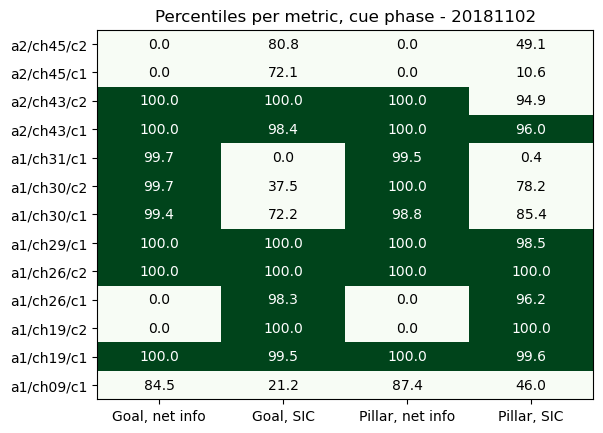

In [13]:
# Stack all results into one big array and visualize
import matplotlib.pyplot as plt

results = 100*np.array((goal_info_perc, goal_sic_perc, pillar_info_perc, pillar_sic_perc)).T
results_pass = np.array((goal_info_pass, goal_sic_pass, pillar_info_pass, pillar_sic_pass)).T
metric_labels = ['Goal, net info', 'Goal, SIC', 'Pillar, net info', 'Pillar, SIC']

plt.figure()
ax = plt.gca()
plt.title(f'Percentiles per metric, cue phase - {day_dir}')
plt.pcolormesh(results_pass, cmap='Greens')
plt.xticks(np.arange(0.5, results.shape[1]+0.5), labels=metric_labels)
plt.yticks(np.arange(0.5, results.shape[0]+0.5), labels=cell_labels)
for i, row in enumerate(results):
    for j, val in enumerate(row):
        if results_pass[i,j] == 1:
            ax.text(j+0.5, i+0.5, f'{val:.1f}', ha='center', va='center', color='w')
        else:
            ax.text(j+0.5, i+0.5, f'{val:.1f}', ha='center', va='center', color='k')
plt.show()